**Group 8 - Midterm Assignment - Mining Massive Data Sets**

---

> ***Group Members***
*   Trần Quốc Bảo - 521H0494
*   Bùi Hải Dương - 521H0220
*   Lê Nguyễn Viết Hiệp - 521H0398
*   Bùi Anh Phú - 521H0508
*   Nguyễn Hoàng Phúc - 521H0511

[Github Repository](https://github.com/scuph-ng/mmds-midterm-2324)

Create folders

In [1]:
!mkdir input output
!mkdir output/f1 output/f2 output/f3 output/f4

Mount Google Drive

In [2]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


Read baskets.csv from Google Drive
- The path should be correct with your Google Drive `MyDrive/MMDS/baskets.csv` or you can change the path

In [3]:
!cp /content/drive/MyDrive/MMDS/baskets.csv /content/input

In [4]:
!ls /content/input

baskets.csv


## Installation

In [5]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
# !wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!cp /content/drive/MyDrive/MMDS/spark-3.1.1-bin-hadoop3.2.tgz .
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

In [6]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.1.1-bin-hadoop3.2"

! echo $JAVA_HOME
! echo $SPARK_HOME

/usr/lib/jvm/java-8-openjdk-amd64
/content/spark-3.1.1-bin-hadoop3.2


## Initializing Spark

In [7]:
import findspark
findspark.init()

In [8]:
import pyspark as spark

print(spark.__version__)

3.1.1


In [11]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession

sc = SparkContext("local", "RDD")

## Read file and preprocessing file

In [12]:
csv_file_path = '/content/input/baskets.csv'

rdd = sc.textFile(csv_file_path)

Get header

In [13]:
header = rdd.first()

In [17]:
header

'Member_number,Date,itemDescription,year,month,day,day_of_week'

# Functional Requirements

## Task 1

### f1: Find the list of distinct products.

In [18]:
# Remove the header
rdd = rdd.filter(lambda line: line != header)

# Extract the product column
products = rdd.map(lambda line: line.split(',')[2])

# Get distinct products
distinct_products = products.distinct()

# Sort distinct products in the ascending order (by name)
distinct_products = distinct_products.sortBy(lambda x: x, ascending=True)

In [19]:
total_count = rdd.count()

first_10_products = distinct_products.take(10)
last_10_products = distinct_products.take(total_count)[-10:]

Define functions

In [26]:
import matplotlib.pyplot as plt

def write_as_file(filename: str, data: list):
  with open(filename, "w") as file:
    for element in data:
      file.write(str(element) + "\n")

def visualize(key, value, x_label: str, y_label: str, title: str):
  plt.figure(figsize=(18, 6))
  plt.bar(key, value, color='skyblue')

  plt.xlabel(x_label)
  plt.ylabel(y_label)
  plt.title(title)

  plt.xticks(rotation=90)
  plt.tight_layout()
  plt.show()

In [27]:
path_f1 = "/content/output/f1/"

output_file_1 = path_f1 + "first_10_products.csv"
output_file_2 = path_f1 + "last_10_products.csv"

write_as_file(output_file_1, first_10_products)
write_as_file(output_file_2, last_10_products)

In [28]:
!cat /content/output/f1/first_10_products.csv

Instant food products
UHT-milk
abrasive cleaner
artif. sweetener
baby cosmetics
bags
baking powder
bathroom cleaner
beef
berries


In [29]:
!cat /content/output/f1/last_10_products.csv

turkey
vinegar
waffles
whipped/sour cream
whisky
white bread
white wine
whole milk
yogurt
zwieback


### f2: Find the list of distinct products and their frequency of being purchased

In [30]:
# Count the frequency of each product
product_frequency = products.countByValue()

# Sort the products by frequency in descending order
sorted_products_frequency = sorted(product_frequency.items(), key=lambda x: x[1], reverse=True)

# Select top 100
top_100_products = sorted_products_frequency[:100]

In [31]:
output_file_f2 = "/content/output/f2/top_100_products.csv"

write_as_file(output_file_f2, top_100_products)

In [33]:
# Extract the product names and frequencies
product_names = [product for product, _ in top_100_products]
frequencies = [count for _, count in top_100_products]

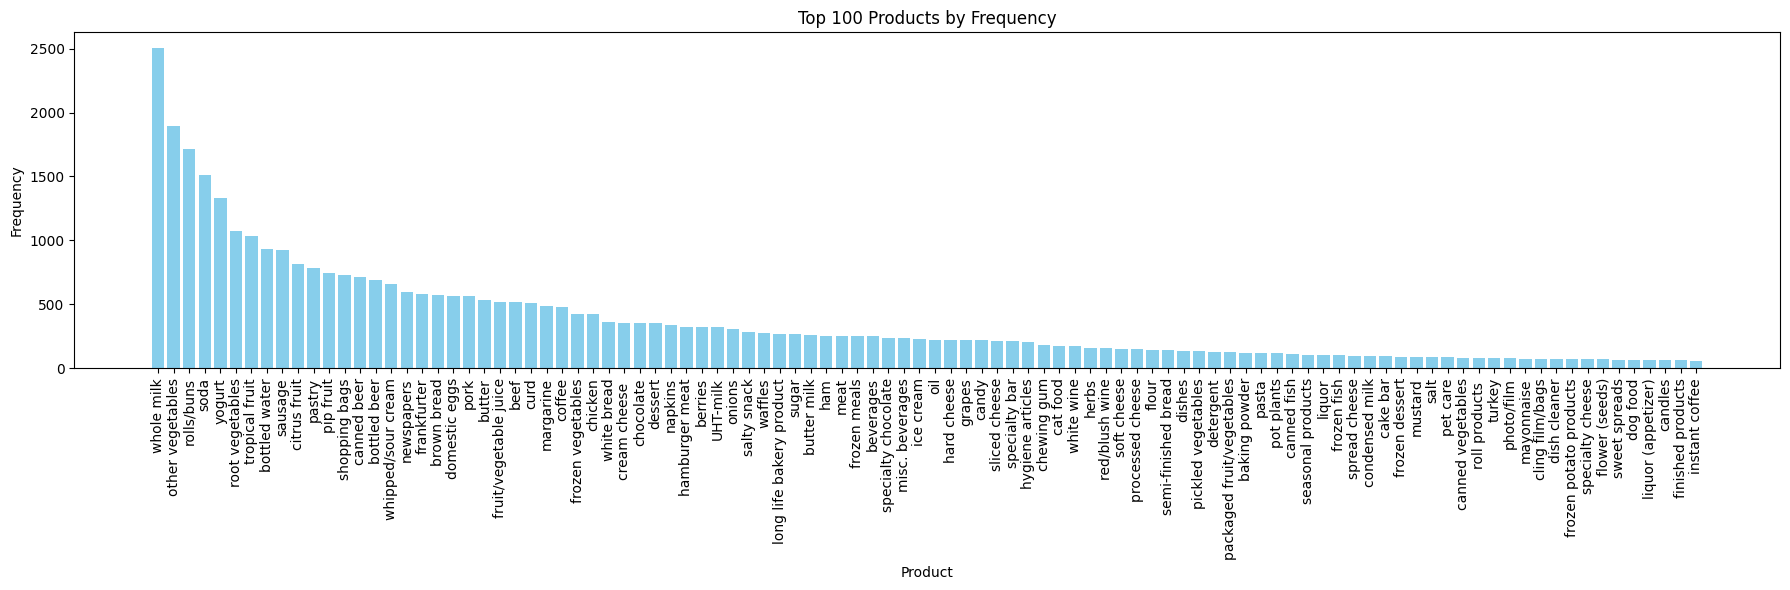

In [34]:
x_label = "Product"
y_label = "Frequency"
title = "Top 100 Products by Frequency"

visualize(key=product_names, value=frequencies, x_label=x_label, y_label=y_label, title=title)

### f3: Find the number of baskets for each member. A basket is a set of distinct products bought by a member in a date.

In [35]:
# Group the data by member and date to identify baskets
baskets = rdd.map(lambda line: ((line.split(',')[0], line.split(',')[1]), line.split(',')[2])).distinct()

# count number of distinct baskets
basket_counts = baskets.map(lambda x: (x[0][0], 1)).reduceByKey(lambda x, y: x + y)

# sort the results (descending)
sorted_basket_counts = basket_counts.sortBy(lambda x: x[1], ascending=False)

# top 100 members
top_100_members = sorted_basket_counts.take(100)

member_names = [member for member, _ in top_100_members]
basket_counts = [count for _, count in top_100_members]

In [36]:
output_file_f3 = "/content/output/f3/top_100_members.csv"
write_as_file(output_file_f3, top_100_members)

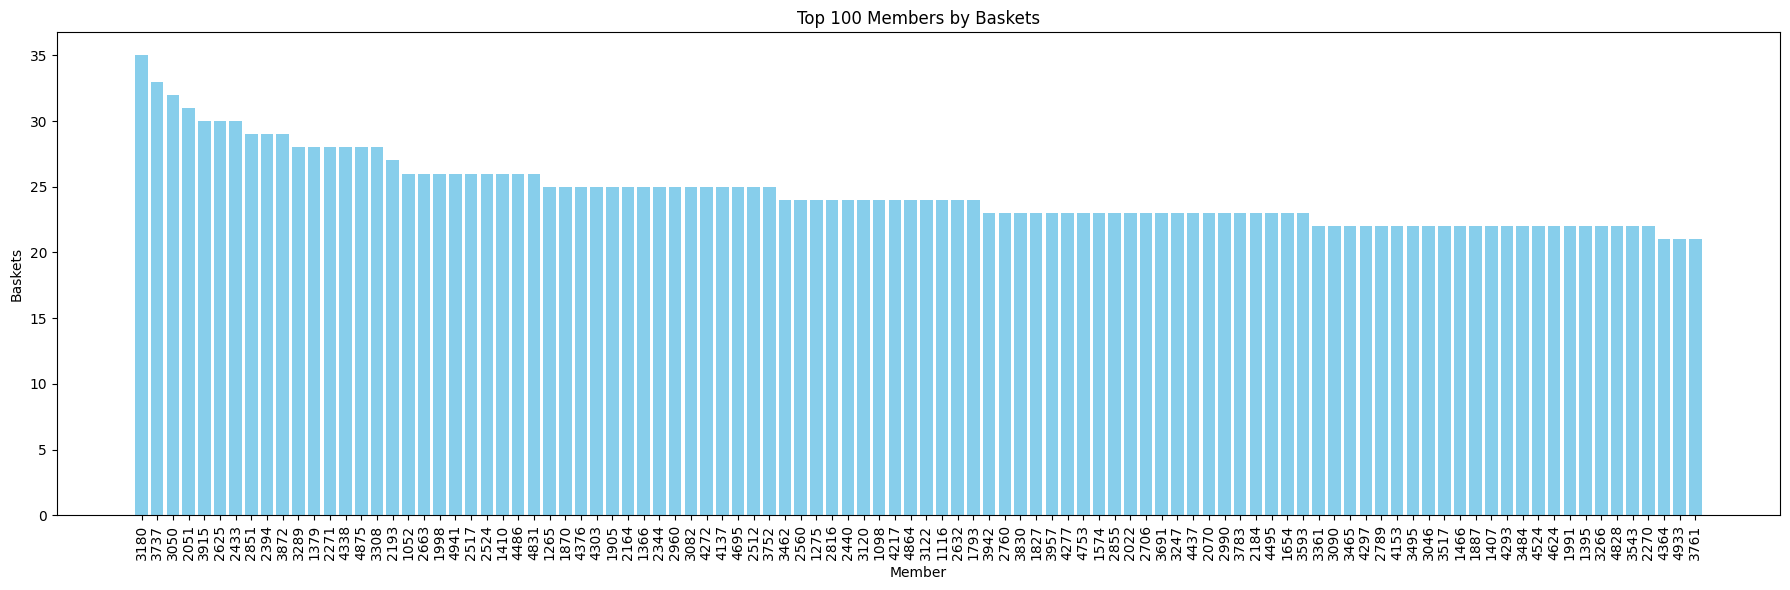

In [38]:
x_label = "Member"
y_label = "Baskets"
title = "Top 100 Members by Baskets"

visualize(key=member_names, value=basket_counts, x_label=x_label, y_label=y_label, title=title)

### f4: Find the member that bought the largest number of distinct products && Find the product that is bought by the most members.

In [39]:
# Count the number of distinct products bought by each member
member_product_counts = baskets.map(lambda x: (x[0][0], x[1])).distinct().map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
max_products_by_aMember = member_product_counts.max(lambda x: x[1])

print("Member who buy the largest number of distunct products:")
print(f"Member Number: {max_products_by_aMember[0]}, Number of Products: {max_products_by_aMember[1]}")

# Count the number of members who bought each product
product_member_counts = baskets.map(lambda x: (x[1], x[0][0])).distinct().map(lambda x: (x[0], 1)).reduceByKey(lambda x, y: x + y)
max_products_by_mostMembers = product_member_counts.max(lambda x: x[1])

print("\nProduct that is bought by the most members:")
print(f"Product Name: {max_products_by_mostMembers[0]}, Number of Members: {max_products_by_mostMembers[1]}")

Member who buy the largest number of distunct products:
Member Number: 2051, Number of Products: 26

Product that is bought by the most members:
Product Name: whole milk, Number of Members: 1786


In [40]:
path_f4 = "/content/output/f4/"

member_bought_largest_distinctProducts_file = path_f4 + "member_products.csv"
write_as_file(member_bought_largest_distinctProducts_file, [max_products_by_aMember])

max_products_by_mostMembers_file = path_f4 + "max_products_member.csv"
write_as_file(max_products_by_mostMembers_file, [max_products_by_mostMembers])

In [43]:
!cat /content/output/f4/member_products.csv

('2051', 26)


In [44]:
!cat /content/output/f4/max_products_member.csv

('whole milk', 1786)
